In [1]:
import numpy as np
import time
import cv2 as cv
import pyrealsense2 as rs
import matplotlib.pyplot as plt
import os

In [2]:
class PointCloud:
    """
    Class to Test Point Cloud Integrity on Framos D435e and Intel Realsense D435
    """
    def __init__(self, cam1, cam2, resolution, fps, laser_power):
        self.cam1 = cam1
        self.cam2 = cam2
        self.resolution = resolution
        self.fps = fps
        self.laser_power = laser_power
        self.img_cnt = 0
        self.cam1_R_list = []
        self.cam2_R_list = []
        self.path = os.path.dirname(os.getcwd())

    def stream(self):
        # Cam1
        pipeline1 = rs.pipeline()
        cfg1 = rs.config()
        cfg1.enable_device(self.cam1)
        cfg1.enable_stream(rs.stream.color,
                           self.resolution[0],
                           self.resolution[1],
                           rs.format.bgr8,
                           self.fps)
        cfg1.enable_stream(rs.stream.depth,
                           self.resolution[0],
                           self.resolution[1],
                           rs.format.z16,
                           self.fps)

        print("[INFO] Starting streaming...")
        profile1 = pipeline1.start(cfg1)
        device1 = profile1.get_device()
        depth_sensor1 = device1.query_sensors()[0]

        # Set laser power to 360 mw
        depth_sensor1.set_option(rs.option.laser_power,self.laser_power)
        emitter1 = depth_sensor1.get_option(rs.option.emitter_enabled)
        print(f"Emitter1 = {emitter1}")

        print("[INFO] Realsense camera ready.")

        # Cam2
        pipeline2 = rs.pipeline()
        cfg2 = rs.config()
        cfg2.enable_device(self.cam2)
        cfg2.enable_stream(rs.stream.color,
                           self.resolution[0],
                           self.resolution[1],
                           rs.format.bgr8,
                           self.fps)
        cfg2.enable_stream(rs.stream.depth,
                           self.resolution[0],
                           self.resolution[1],
                           rs.format.z16,
                           self.fps)

        print("[INFO] Starting streaming...")
        profile2 = pipeline2.start(cfg2)
        device2 = profile2.get_device()
        depth_sensor2 = device2.query_sensors()[0]

        # Set laser power to 360 mw
        depth_sensor2.set_option(rs.option.laser_power, self.laser_power)
        emitter2 = depth_sensor2.get_option(rs.option.emitter_enabled)
        print(f"Emitter2 = {emitter2}")
        print("[INFO] FRAMOS camera ready.")

        start_time = time.time()

        align_to = rs.stream.color
        align = rs.align(align_to)

        c = rs.colorizer()

        # Start streaming
        try:
            while True:
                # Cam1
                frame1 = pipeline1.wait_for_frames()
                # Align color and depth frame
                aligned_frame1 = align.process(frame1)

                color_frame1 = aligned_frame1.get_color_frame()
                depth_frame1 = aligned_frame1.get_depth_frame()

                if not color_frame1 or not depth_frame1:
                    continue

                # Colorize depth frame
                color_depth_frame1 = c.process(depth_frame1)

                color_img1 = np.asanyarray(color_frame1.get_data())
                depth_img1 = np.asanyarray(color_depth_frame1.get_data())

                # Cam2
                frame2 = pipeline2.wait_for_frames()
                # Aligned color and depth frame
                aligned_frame2 = align.process(frame2)

                color_frame2 = aligned_frame2.get_color_frame()
                depth_frame2 = aligned_frame2.get_depth_frame()

                if not color_frame2 or not depth_frame2:
                    continue

                # Colorize depth frame
                color_depth_frame2 = c.process(depth_frame2)

                color_img2 = np.asanyarray(color_frame2.get_data())
                depth_img2 = np.asanyarray(color_depth_frame2.get_data())

                # Stack color and depth image horizontally
                # realsense_img = np.hstack((color_img1,depth_img1))
                framos_img = np.hstack((color_img2, depth_img2))

                # OpenCV Window
                cv.namedWindow('Realsense Stream', cv.WINDOW_AUTOSIZE)
                cv.imshow('Realsense Stream', depth_img1)

                cv.namedWindow('FRAMOS Stream', cv.WINDOW_AUTOSIZE)
                cv.imshow('FRAMOS Stream', framos_img)

                key = cv.waitKey(1)

                if key & 0xFF == ord('q') or key == 27 or self.img_cnt == 8:
                    cv.destroyAllWindows()
                    break

                # Capture the image every 30 min from streaming
                cur_time = time.time()

                if cur_time - start_time >= 1:  # 1800s = 30 minutes
                    realsense_img_name = self.path + f'/img/test/realsense/realsense_{str(self.img_cnt)}.png'
                    framos_img_name = self.path + f'/img/test/framos/framos_{str(self.img_cnt)}.png'
                    cv.imwrite(realsense_img_name,depth_img1)
                    cv.imwrite(framos_img_name,depth_img2)

                    print(f'Saved image_{str(self.img_cnt)}')

                    # Calculate R = black pixels / total pixels
                    r_realsense, r_framos = self.calculate_r(depth_img2, depth_img1)
                    print(f'Realsense R is: {r_realsense}')
                    print(f'Framos R is: {r_framos}')
                    self.cam1_R_list.append(r_framos)
                    self.cam2_R_list.append(r_realsense)

                    start_time = time.time()
                    self.img_cnt += 1

        finally:
            pipeline1.stop()
            pipeline2.stop()

    '''
    Calculate the amount of black pixels compared to white pixels in Charuco Board
    '''
    def calculate_r(self, image_realsense, image_framos):
        # Charuco Board ROI
        ROI_realsense = [(560,808),(71,435)]   # Format is [(Range of x),(Range of y)]
        ROI_framos = [(571,821),(125,492)]

        # Crop Img to only cover the region of Interest
        image_realsense = image_realsense[ROI_realsense[0][0]:ROI_realsense[0][1], ROI_realsense[1][0]:ROI_realsense[1][1]]
        image_framos = image_framos[ROI_framos[0][0]:ROI_framos[0][1], ROI_framos[1][0]:ROI_framos[1][1]]

        # Calculate Total Pixels of ROI
        total_pix_realsense = (ROI_realsense[0][1]-ROI_realsense[0][0])*(ROI_realsense[1][1]-ROI_realsense[1][0])
        total_pix_framos = (ROI_framos[0][1]-ROI_framos[0][0])*(ROI_framos[1][1]-ROI_framos[1][0])

        # Convert Img to Gray Scale to be able to Count Num of Black Pixels
        image_realsense = cv.cvtColor(image_realsense, cv.COLOR_BGR2GRAY)
        image_framos = cv.cvtColor(image_framos, cv.COLOR_BGR2GRAY)

        # countNonZero() only counts the number of non-black pixels
        white_pix_realsense = cv.countNonZero(image_realsense)
        white_pix_framos = cv.countNonZero(image_framos)
        black_pixels_realsense = total_pix_realsense - white_pix_realsense
        black_pixels_framos = total_pix_framos - white_pix_framos
        # Calculate the amount of Black Pixels in Given ROI
        r_framos = black_pixels_framos / total_pix_framos
        r_realsense = black_pixels_realsense / total_pix_realsense

        return r_framos, r_realsense

    def plot_result(self):
        # 0 - 16h with an increment of 0.5h
        time_list = np.arange(0.5,4.5,0.5)

        # R vs. Time
        plt.figure()
        plt.plot(time_list,self.cam1_R_list,'-o',label='Realsense')
        plt.plot(time_list,self.cam2_R_list,'-o',label='Framos')
        plt.title('R  vs. Time')
        plt.xlabel('Time(h)')
        plt.ylabel('Black Pixels / Total Pixels')
        plt.legend()
        plt.grid(True)
        plt.savefig(self.path+'/plot/test/R_vs_Time.png')
        print("Saved image!")

In [3]:
def cam_cfg():
    resolution = (1280,720)
    fps = 30
    laser_power = 360.0
    path = os.path.dirname(os.getcwd())
    ctx = rs.context()
    devices = ctx.query_devices()
    ctx = rs.context()
    cam_dict = {}
    for d in devices:
        cam_dict[d.get_info(rs.camera_info.name)] = d.get_info(rs.camera_info.serial_number)

    cfg = [cam_dict, resolution, fps, laser_power]

    return cfg


In [4]:
def main():
    cfg = cam_cfg()
    framos_cam = cfg[0]['FRAMOS D435e']
    realsense_cam = cfg[0]['Intel RealSense D435']

    test1 = PointCloud(realsense_cam, framos_cam, cfg[1], cfg[2], cfg[3])
    test1.stream()

    print(f'Framos R: {test1.cam1_R_list}')
    print(f'Realsense R: {test1.cam2_R_list}')

    test1.plot_result()

[INFO] Starting streaming...
Emitter1 = 1.0
[INFO] Realsense camera ready.
[INFO] Starting streaming...
Emitter2 = 1.0
[INFO] FRAMOS camera ready.
Saved image_0
Realsense R is: 0.4906594005449591
Framos R is: 0.5406438319744772
Saved image_1
Realsense R is: 0.4975149863760218
Framos R is: 0.5402893477490252
Saved image_2
Realsense R is: 0.5002615803814714
Framos R is: 0.5417515951790145
Saved image_3
Realsense R is: 0.500534059945504
Framos R is: 0.5417072846508331
Saved image_4
Realsense R is: 0.5051880108991825
Framos R is: 0.5407213753987947
Saved image_5
Realsense R is: 0.5032152588555858
Framos R is: 0.5414192662176533
Saved image_6
Realsense R is: 0.5033242506811989
Framos R is: 0.5407656859269763
Saved image_7
Realsense R is: 0.5012861035422344
Framos R is: 0.5417848280751506
Framos R: [0.5406438319744772, 0.5402893477490252, 0.5417515951790145, 0.5417072846508331, 0.5407213753987947, 0.5414192662176533, 0.5407656859269763, 0.5417848280751506]
Realsense R: [0.4906594005449591, 0

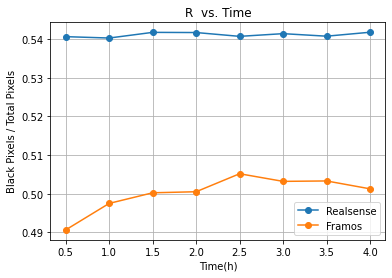

In [5]:
if __name__ == '__main__':
    try:
        main()
    except:
        KeyError